In [92]:
!pip install konlpy

In [93]:
!nvidia-smi

Thu Aug 12 02:37:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    35W / 250W |   1001MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [94]:
!cp '/content/drive/MyDrive/gh/NLP/nlp_DL/Transformer/preprocess.py' .

In [95]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [96]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

In [147]:
DATA_IN_PATH = '/content/drive/MyDrive/gh/NLP/nlp_DL/Transformer/data_in/'
DATA_OUT_PATH = '/content/drive/MyDrive/gh/NLP/nlp_DL/Transformer/data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIG = 'data_configs.json'



In [148]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [149]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS, 'rb'))
prepro_config = json.load(open(DATA_IN_PATH + DATA_CONFIG, 'r'))

In [150]:
MODEL_NAME = 'transformer_kor'
BATCH_SIZE = 24
MAX_SEQUENCE = 25
EPOCH = 30
VALIDATION_SPLIT = 0.1

word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']

sos_idx = prepro_config['sos_symbol']
eos_idx = prepro_config['eos_symbol']
vocab_size = prepro_config['vocab_size']


kargs = {'model_name': MODEL_NAME, 
         'num_layers': 2, 
         'd_model': 512, #512 로 시작해서 2048, 그리고 다시 512
         'num_heads':8,
         'dff':2048, 
         'input_vocab_size':vocab_size,
         'output_vocab_size':vocab_size,
         'maximum_position_encoding':MAX_SEQUENCE, # 처음에 input encoding 할때 positional encoding(위치정보) (sin,cos func) max_sequence 만큼 값이 있어야 한다.
         'end_token_idx': word2idx[eos_idx],
         'rate':0.1

         }

In [151]:
# 문장의 길이가 MAXLEN 이 안되는 경우가 있다. 나머지 빈공간은 셀프 어텐션을 하면 안되니까 0으로 마스킹 처리한다.
def create_padding_mask(seq): # 입력값은 [batchsize, seq_len] 차원을 늘려줘야한다. 5행 
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # 0은 padding equal 함수를 쓰면 0 이면 True 가 return

    return seq[:, tf.newaxis, tf.newaxis, :] # 입력의 차원을 늘려준다, (batchsize,1,1,seqlen)

In [152]:
def create_look_ahead_mask(size):
    # 문장 25개? (25,25)

    # tf.linalg.band_part? ->> 
    mask = 1-tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [153]:
#tf.linalg.band_part(input,-1,0) # upper triangle part

In [154]:
#1 - tf.linalg.band_part(input,-1,0) # upper triangle part

In [155]:
#size = 4
#tf.ones((size,size))

In [156]:
#tf.linalg.band_part(tf.ones((size,size)),-1,0)

In [157]:
#1- tf.linalg.band_part(tf.ones((size,size)),-1,0)
# 결론 마스킹을 만들어주는것임

In [158]:
###########################################################

In [159]:
# look_ahead = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

In [160]:
def create_masks(input, target):
    enc_padding_mask = create_padding_mask(input) # 
    dec_padding_mask = create_padding_mask(input) # 멀티헤드 어텐션에서 사용할것임.
    
    # target (sample, seq-len) 이기때문에 seq_len 을 가져오는것임 
    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1]) # 과거의 단어로 현제의 단어를 예측.
    dec_target_padding_mask = create_padding_mask(target)
    
    # 2개를 합친다 maximum [배열a],[배열b] 두 배열의 각각 위치에서 높은값을 가져온다?
    # >> 나중에 combined_mask 차원 디버깅 꼭 해볼것 >> 아마 비교해서 마스크 처리 되어있는 부분은 제외하고 가져오는것으로 예상됨
    # 결론 우리가 하는것에서는 원래 마스킹을 해야하는부분은 마스킹을 하고 뒤에 패딩 되어있는 부분도 마스킹을 한다.
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [161]:
#################################################################
#x = tf.constant([-5.,0.,0.,0.])
#y = tf.constant([-3.])
#tf.math.maximum(x,y)
## 결론 우리가 하는것에서는 원래 마스킹을 해야하는부분은 마스킹을 하고 뒤에 패딩 되어있는 부분도 마스킹을 한다.
# 배열의 랭스가 적을때는 브로드케스팅해서 가져온다
#################################################################

In [162]:
# 디버깅용
#enc_padding_mask,look_ahead_mask,dec_padding_mask = create_masks(index_inputs, index_outputs)

In [163]:
#enc_padding_mask

In [164]:
#look_ahead_mask

In [165]:
#dec_padding_mask

In [166]:
# 봐도 보기 힘들다 너무 길어서
#############################################

In [167]:
# Positional Encoding
# 2가지 구현이 있음. 논문에서는 그냥 수식만 주고 Positional Encoding 을 한다 고만 함
## 수식 캡쳐해서 임베딩할것
def get_angles(pos, i, d_model):
    #angle_rate = 1/np.power(10000,(2*i//2) /np.float(d_model))
    angle_rate = 1/np.power(10000,(2*i//2)/np.float(d_model))
    #print(angle_rate)
    return pos * angle_rate

In [168]:
np.power(100,2)

10000

In [169]:
#angle_rate = 1/np.power(10000,(2*i)/np.float(d_model))

In [170]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:,0::2])
    #print(angle_rads)
    angle_rads[:, 1::2] = np.cos(angle_rads[:,1::2])
    #print(angle_rads)

    # ... 은 뭐지 ? 
    # 예를들어 A = (50,) 이건 1차원인데 [A,:] 이렇게하면 2차원으로 바뀜 근데 3차원이면 이게 안됨..
    # 우리같은 경우 (50,512) 이므로 이걸 가져간 상태에서 차원을 하나 추가하라는 이야기임
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


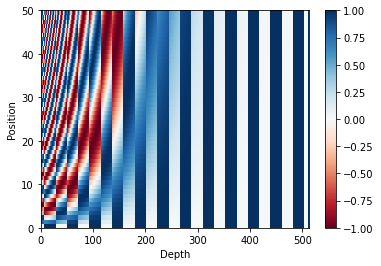

In [171]:
pos_encoding = positional_encoding(50, 512)
#print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [172]:
def scaled_dot_product_attention(q,k,v,mask):
    matmul_qk = tf.matmul(q,k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1],tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis =-1)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [173]:
class MultiHeadAttention(tf.keras.layers.Layer):
    # ** 두개면 Dic unpacking 
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        # 0인지 검사한다. 
        # 기존에 있는 단어벡터 행렬에서 8개로 잘 나눠야 512가 되는데 나중에 나온 결과를 head 수 만큼 더해줘야 한다 
        # 그래서 검사한다. 나누어 떨어지는지 ? 검사
        assert self.d_model % self.num_heads == 0 

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        
        # perm 차원을 바꿔준다 [30,1,8,64] >> [30,8,1,64] 변경해준다
        # 이유는 곱해줘야 하기 때문이라고 한다.
        # perm 번호순으로 자리를 바꿔준다고 생각하면됨
        return tf.transpose(x, perm=[0,2,1,3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0] # 맨 앞이 batch_size

        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weight = scaled_dot_product_attention(q,k,v,mask)

        # 행렬곱 계산이 끝났기 때문에 원래 형태로 바꿔준다. 
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weight


In [174]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
                               tf.keras.layers.Dense(kargs['dff'], activation='relu'),
                               tf.keras.layers.Dense(kargs['d_model'])
    ])

In [175]:
# 피드포워층이 있는 이유가 뭘까 ?
# 실제 학습이 되는 부분 ? 
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)

        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)

        out2 = self.layernorm2(out1 + ffn_output)

        return out2
        

In [176]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']
        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.enc_layers = [EncoderLayer(**kargs) for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])
        ## 여기까지는 정의 ##

 

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        # https://www.tensorflow.org/api_docs/python/tf/cast 
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x




In [177]:
# 0812 decoderlayer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)
        
        # 드롭아웃과 노말라이제이션 3개 만들어줘야한다 디코더레이어쪽
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.layernorm3 = tf.keras.layers.LayerNormalization()

        # rate 를 0.1 0.2 0.5 등으로 바꿔서 성능체크해보자
        # Dropout 은 일반화를 시키기 위해 그니까 오버피팅을 막기위해 하는것
        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])

    # look_ahead_mask >>> 디코더 처음 입력쪽 
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weight_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weight_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)

        # 안 쓰는데 왜 block1 ,2 를 리턴할까? 생각해보자 아마 attention 을 확인하기위해 하는것같고 
        # 학습시킬때 사용하지는 않는것같다.
        return out3, attn_weight_block1, attn_weight_block2


In [178]:
# 디코더레이어를 6개를 가지고 있는 디코더를 만들자
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']
        
        self.embedding = tf.keras.layers.Embedding(kargs['output_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) for _ in range(self.num_layers)]

        self.drop_out = tf.keras.layers.Dropout(kargs['rate'])

    def call (self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1] # >> 배치사이즈별 시퀀스랭스 그래서 1에서 가져온다
        attention_weight = {} # 어텐션 확인하기위해

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.drop_out(x)

        ## 여기까지가 디코더레이어 들어가기전 까지의 과정

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
            attention_weight['decoder_layers{}_block1'.format(i + 1)] = block1
            attention_weight['decoder_layers{}_block2'.format(i + 1)] = block2

        return x, attention_weight


In [179]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])

        self.end_token_idx = kargs['end_token_idx']
        
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)
        
        #final 에서 dense 에서 나와야 하는것은 단어를 뽑아와야한다?
        self.final_layer = tf.keras.layers.Dense(kargs['output_vocab_size'])

    def call(self, x):
        input, output = x

        # 입력들어와서 인코더와 디코더에서 들어오는 패딩
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(input, output)
        enc_output = self.encoder(input, enc_padding_mask)
        # 인코더는 돌았다

        # now decoder

        dec_output, _ = self.decoder(output, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output
    
    def inference(self, x):
        input = x
        # 아웃풋이 들어갈 공간을 만들어주자
        output = tf.expand_dims([SOS_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(input, output)
        enc_output= self.encoder(input, enc_padding_mask)

        predict_tokens = []
        for t in range(MAX_SEQUENCE):
            dec_output, _ = self.decoder(output, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            
            predict_tokens.append(pred_token)
            output = tf.expand_dims([SOS_INDEX] + predict_tokens, 0) 
            _, look_ahead_mask, _ = create_masks(input, output)

        return predict_tokens
        

In [180]:
# 지금까지는 모델을 만들었고
# 지금부터 학습을 시켜야한다.

# logits true >>> softmax 처리부분
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

In [181]:
def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [182]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])

In [183]:

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = ModelCheckpoint(checkpoint_path, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True)

In [184]:
history = model.fit([index_inputs, index_outputs],
                    index_targets,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT,
                    callbacks=[earlystop_callback, cp_callback])


Epoch 1/30
444/444 [==============================] - 96s 200ms/step - loss: 1.5408 - accuracy: 0.7931 - val_loss: 1.5997 - val_accuracy: 0.7962

Epoch 00001: val_loss improved from inf to 1.59971, saving model to /content/drive/MyDrive/gh/NLP/nlp_DL/Transformer/data_out/transformer_kor/weights.h5
Epoch 2/30
444/444 [==============================] - 87s 197ms/step - loss: 1.2325 - accuracy: 0.8024 - val_loss: 1.4948 - val_accuracy: 0.8072

Epoch 00002: val_loss improved from 1.59971 to 1.49484, saving model to /content/drive/MyDrive/gh/NLP/nlp_DL/Transformer/data_out/transformer_kor/weights.h5
Epoch 3/30
444/444 [==============================] - 87s 196ms/step - loss: 1.0709 - accuracy: 0.8121 - val_loss: 1.4593 - val_accuracy: 0.8157

Epoch 00003: val_loss improved from 1.49484 to 1.45927, saving model to /content/drive/MyDrive/gh/NLP/nlp_DL/Transformer/data_out/transformer_kor/weights.h5
Epoch 4/30
444/444 [==============================] - 88s 197ms/step - loss: 0.9355 - accuracy:

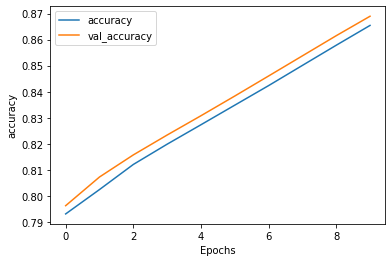

In [185]:
plot_graphs(history, 'accuracy')

In [186]:
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, 'weights.h5'))

In [187]:
word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']


In [194]:
text = '저녁 뭐 먹을까?'
test_index_inputs, _ = enc_processing([text], word2idx)
outputs = model.inference(test_index_inputs)

print(" ".join([idx2word[str(o)] for o in outputs]))

맛있는 거 드세요
